# 5. Benchmarking of Different Encodings

### Overview

In this notebook, we are going to explore best practices for benchmarking quantum optimization algorithms. We will
- Define appropriate metrics for quantum optimization algorithms and discuss pros and cons.
- Define a Solver configuration with different parameters
- Run the optimizations.
- Plot and Analyse the Results of the runs

In [1]:
import logging

import numpy as np
import pandas as pd
import seaborn as sns

# Luna imports
from luna_quantum import Solution, algorithms
from luna_quantum.solve.parameters.algorithms.base_params import ScipyOptimizerParams
from luna_quantum.solve.parameters.algorithms.quantum_gate.flex_qaoa import (
    CombinedOptimizerParams,
    PipelineParams,
)
from luna_quantum.util.log_utils import Logging, config

# Import model data
from model.data import ConventionCenter, Schedule, SessionChair
from model.model import optimization_model
from model.visualization import plot_floor_plan

# Import utils (from last notebooks)
from utils.algorithm import MyQAOA
from utils.transformations import qubo_pipeline, xy_pipeline

%load_ext dotenv
%dotenv

# Disable all logging
Logging.set_level(log_level=logging.NOTSET)
config.LUNA_LOG_DISABLE_SPINNER = True

## The Session Chair Assignment Problem, Again

We use the same problem as investageted in the last notebooks here as well.

(<Figure size 1000x500 with 1 Axes>, <Axes: >)

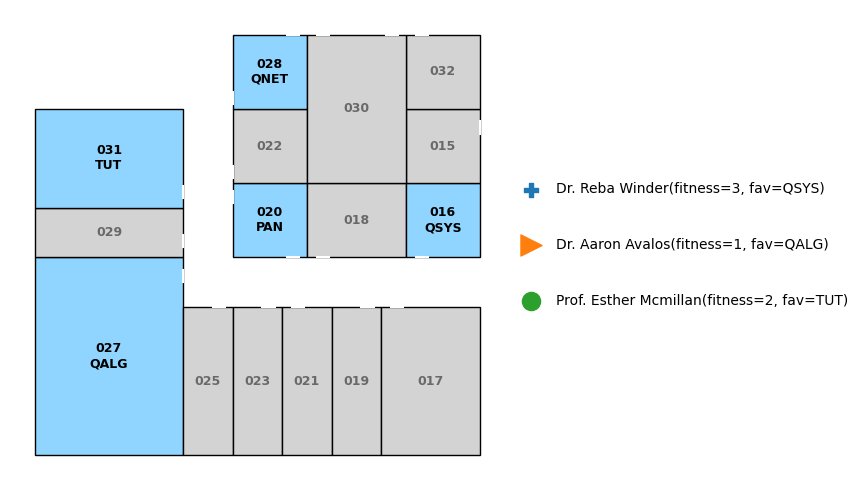

In [2]:
center = ConventionCenter.generate()
schedule = Schedule.random(5, center, seed=5)
chairs = SessionChair.random_chairs(3, schedule=schedule, seed=2)

satisfaction = 2

plot_floor_plan(center, schedule=schedule, chairs=chairs)

In [3]:
x, model = optimization_model(center, schedule, chairs, satisfaction=satisfaction)

## Figures of Merit

The Paper ["Towards Robust Benchmarking of Quantum Optimization Algorithms"](https://arxiv.org/abs/2405.07624) discusses benchmarking figures of merit and best practices for quantum optimization.
The core problem with quantum optimization (or approximate optimization) is that we have a probabilistic output of solution candidates. There are a few methods for quantifying an algorithm's performance. Here is the definition of a selection of metrics we would like to implement to benchmark the performance of our implementation of the encoding methods in comparison to FlexQAOA.

- Expectation Value: $C(\beta, \gamma) = \bra{\beta, \gamma}  C  \ket{\beta, \gamma}$
- **Feasibility Ratio**: $f(\beta, \gamma) = \left|\braket{\mathcal{F}|\beta, \gamma}\right|^2$
- **Approximation Ratio**: $r(\beta, \gamma) = C(\beta, \gamma) / C^*$. Needs to be constrained to feasible solutions (only valid in combination with feasibility ratio)
- **Probability** of sampling the **optimal solution**: $$P_\text{opt} = \sum_{x^* \in X^*}|\braket{x^*|\beta, \gamma}|^2, $$where $X^*$ is the set of all optimal solutions, i.e. $X^* = \{x \in \{0, 1\}^n \,|\, C(x) = C^*\}$.
- **Probability** of sampling the a **90% optimal solution**: $P_\text{90} = \sum_{x \in X^{90}}|\braket{x|\beta, \gamma}|^2$, where $X^{90}  = \{x \in \{0, 1\}^n \,|\, |C(x) - C^*| / C^* \leq 0.1 \}$
- **Time-to-Solution (TTS)** in terms of circuit layer executions, i.e. depth $d$ times required measurements, given through $P_\text{opt}$. The execution time of an algorithm is proportional to circuit depth.
  $$ \text{TTS} = d \left\lceil \frac{\log 0.01}{\log (1 - P_\text{opt})} \right\rceil $$

For this, we first implement the `get_metrics` method, which evaluates these metrics for a given solution. Certain metrics have additional requirements. For instance, $P_\text{opt}$ requires knowledge of the optimal solution, whereas $TTS$ also needs the circuit depth of the quantum circuit.

In [4]:
def get_metrics(
    solution: Solution, optimal: float | None = None, circuit_depth: int | None = None
) -> dict[str, float]:
    """Computes the metrics for a given solution.

    Parameters
    ----------
    solution: Solution
        The solution output from the algorithm excecution.
    optimal: float | None
        The optimal value of the optimization problem. If none provided 'p_opt', 'p_90'
        and 'tts' cannot be computed.
    circuit_depth: float | None
        The circuit depth of the algorithm. If none provided 'tts' cannot be computed.

    Returns
    -------
    dict[str, float]
        Metrics dict, featuring 'approximation_ratio', 'best_found',
        'feasibility_ratio', 'p_opt', 'p_90' and 'tts'
    """

    feasible_solutions = solution.filter_feasible()

    # Compute the feasibility ratio and the approximation ratio of feasible samples.
    # Hint: Use utility functions provided by the solutions object `.feasibility_ratio()` and `.expectation_ratio`
    ##TASK>
    fr = solution.feasibility_ratio()
    ev = feasible_solutions.expectation_value()
    ##<TASKEND

    metrics = {
        "expectation_value": ev,
        "approximation_ratio": ev / opt,
        "feasibility_ratio": fr,
    }

    # Compute p_opt and p_90, if optimal is not defined, ignore
    total = solution.counts.sum()
    if optimal is not None:
        # Compute p_opt and p_90 using the definition from above. Only feasible solutions are important
        ##TASK>
        p_opt = (
            feasible_solutions.counts[
                np.isclose(feasible_solutions.obj_values, optimal)
            ].sum()
            / total
        )
        p_90 = (
            feasible_solutions.counts[
                np.abs(feasible_solutions.obj_values - optimal) / np.abs(optimal) < 0.1
            ].sum()
            / total
        )
        ##<TASKEND
        metrics["p_opt"] = p_opt
        metrics["p_90"] = p_90

    # Compute TTS, if p_opt and circuit_depth is available
    p_opt = metrics.get("p_opt", None)
    if p_opt is not None and circuit_depth is not None:
        # Compute TTS from the definition above. Also consider edge cases when p_opt = 1 or p_opt 0.
        ##TASK>
        if p_opt == 0:
            tts = np.inf
        elif p_opt == 1:
            tts = circuit_depth
        else:
            tts = circuit_depth * np.ceil(np.log(0.01) / np.log(1 - p_opt))
        ##<TASKEND
        metrics["tts"] = tts

    return metrics

## Benchmarking Configuration

In [5]:
# QAOA layers to investigate
reps_range = range(1, 9)

# Fixed optimizer Params
optimizer = ScipyOptimizerParams(method="COBYLA", options={"rhobeg": 0.1}, maxiter=100)

# The algorithms dict
algos = {
    "flex_qaoa(xy)": algorithms.FlexQAOA(optimizer=optimizer),
    "flex_qaoa(xy,copt)": algorithms.FlexQAOA(
        optimizer=CombinedOptimizerParams(fine_tune=optimizer)
    ),
    "flex_qaoa(qubo)": algorithms.FlexQAOA(
        pipeline=PipelineParams(one_hot=None, quadratic_penalty={"penalty": 50}),
        optimizer=optimizer,
    ),
    "my_qaoa(xy)": MyQAOA(pass_manager=xy_pipeline, optimizer=optimizer),
    "my_qaoa(qubo)": MyQAOA(pass_manager=qubo_pipeline, optimizer=optimizer),
}

In [6]:
# The optimal solution can be retrieved using SCIP
opt = algorithms.SCIP().run(model).result().best().obj_value

In [7]:
data = []

# Dispatch Jobs
print("Starting jobs...")
for aname, algorithm in algos.items():
    for r in reps_range:
        print(f"{aname:>20} {r}")
        # Set the QAOA layers and run the algorithm.
        ##TASK>
        algorithm.reps = r
        job = algorithm.run(model)
        ##<TASKEND
        if isinstance(algorithm, MyQAOA):
            circuit_depth = algorithm.circuit.depth()
        else:
            circuit_depth = None
        data.append({"name": aname, "reps": r, "job": job, "depth": circuit_depth})

Starting jobs...
       flex_qaoa(xy) 1
       flex_qaoa(xy) 2
       flex_qaoa(xy) 3
       flex_qaoa(xy) 4
       flex_qaoa(xy) 5
       flex_qaoa(xy) 6
       flex_qaoa(xy) 7
       flex_qaoa(xy) 8
  flex_qaoa(xy,copt) 1
  flex_qaoa(xy,copt) 2
  flex_qaoa(xy,copt) 3
  flex_qaoa(xy,copt) 4
  flex_qaoa(xy,copt) 5
  flex_qaoa(xy,copt) 6
  flex_qaoa(xy,copt) 7
  flex_qaoa(xy,copt) 8
     flex_qaoa(qubo) 1
     flex_qaoa(qubo) 2
     flex_qaoa(qubo) 3
     flex_qaoa(qubo) 4
     flex_qaoa(qubo) 5
     flex_qaoa(qubo) 6
     flex_qaoa(qubo) 7
     flex_qaoa(qubo) 8
         my_qaoa(xy) 1
         my_qaoa(xy) 2
         my_qaoa(xy) 3
         my_qaoa(xy) 4
         my_qaoa(xy) 5
         my_qaoa(xy) 6
         my_qaoa(xy) 7
         my_qaoa(xy) 8
       my_qaoa(qubo) 1
       my_qaoa(qubo) 2
       my_qaoa(qubo) 3
       my_qaoa(qubo) 4
       my_qaoa(qubo) 5
       my_qaoa(qubo) 6
       my_qaoa(qubo) 7
       my_qaoa(qubo) 8


In [8]:
# Retrieve Results
print("\nRetrieving jobs...")
for r in data:
    print(f"{r['name']:>20} {r['reps']}")
    job = r.pop("job")
    sol = job.result()
    r.update(get_metrics(sol, opt, r["depth"]))
    if r["depth"] is None:
        r["tts"] = job.metadata.get("metrics", {}).get("tts")
        r["p_opt"] = job.metadata.get("metrics", {}).get("p_opt")


df = pd.DataFrame(data)


Retrieving jobs...
       flex_qaoa(xy) 1
       flex_qaoa(xy) 2
       flex_qaoa(xy) 3
       flex_qaoa(xy) 4
       flex_qaoa(xy) 5
       flex_qaoa(xy) 6
       flex_qaoa(xy) 7
       flex_qaoa(xy) 8
  flex_qaoa(xy,copt) 1
  flex_qaoa(xy,copt) 2
  flex_qaoa(xy,copt) 3
  flex_qaoa(xy,copt) 4
  flex_qaoa(xy,copt) 5
  flex_qaoa(xy,copt) 6
  flex_qaoa(xy,copt) 7
  flex_qaoa(xy,copt) 8
     flex_qaoa(qubo) 1
     flex_qaoa(qubo) 2
     flex_qaoa(qubo) 3
     flex_qaoa(qubo) 4
     flex_qaoa(qubo) 5
     flex_qaoa(qubo) 6
     flex_qaoa(qubo) 7
     flex_qaoa(qubo) 8
         my_qaoa(xy) 1
         my_qaoa(xy) 2
         my_qaoa(xy) 3
         my_qaoa(xy) 4
         my_qaoa(xy) 5
         my_qaoa(xy) 6
         my_qaoa(xy) 7
         my_qaoa(xy) 8
       my_qaoa(qubo) 1
       my_qaoa(qubo) 2
       my_qaoa(qubo) 3
       my_qaoa(qubo) 4
       my_qaoa(qubo) 5
       my_qaoa(qubo) 6
       my_qaoa(qubo) 7
       my_qaoa(qubo) 8


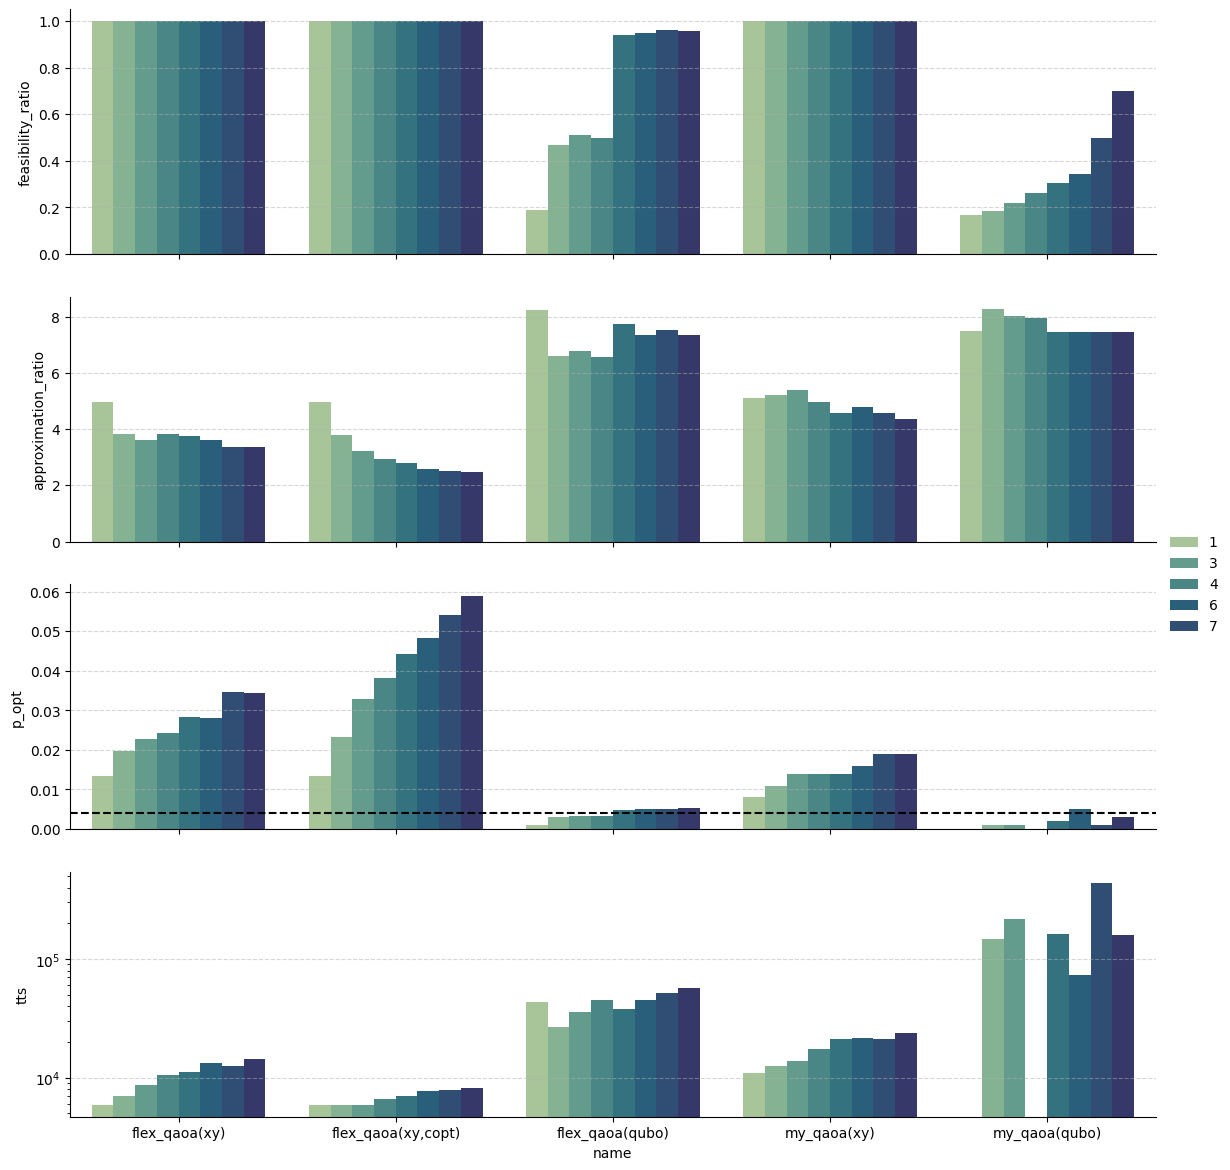

In [9]:
# Plot metrics
dfx = df.melt(
    id_vars=["name", "reps"],
    value_vars=["feasibility_ratio", "approximation_ratio", "p_opt", "tts"],
    var_name="metric",
)
fg = sns.FacetGrid(dfx, row="metric", aspect=4, sharey=False)

fg.map_dataframe(sns.barplot, x="name", y="value", hue="reps", palette="crest")

fg.axes_dict["tts"].set_yscale("log")

for k, v in fg.axes_dict.items():
    v.set_ylabel(k)
    v.set_title("")
    v.grid(which="major", axis="y", linestyle="dashed", alpha=0.5)

fg.axes_dict["p_opt"].axhline(y=1 / 3**5, linestyle="dashed", color="k")

fg.add_legend()

### Analysis

The following observations can be made from the benchmarks
- **FlexQAOA typically performs better than our implementation.** Possible Explanation: Our implementation entirely depends on SamplerV2 and, therefore, shot noise. This is not the case for FlexQAOA, where the optimizer has access to exactly evaluated expectation values, making optimization better
- **The Combined Optimizer improves Performance.** The Combined Optimizer that first optimizes the linear schedule and then optimizes individual parameters works better and has a more predictable performance curve with increasing layers.
- **Feasibility gets better but not Approximation Ratio.** In the penalty approach, we can clearly observe that the feasibility ratio improves with increasing number of QAOA layers. However, the approximation ratio of feasible samples does not improve. This means that the optimization focuses on finding feasible solutions instead of good solutions.

---

## 🎉 Congratulations!

You've successfully completed this tutorial! We hope you found it helpful and informative.

### 📖 References & Further Reading
This tutorial was built upon the following resources:

- D. Bucher et al., 2024: "Towards Robust Benchmarking of Quantum Optimization Algorithms" [[Paper]](https://arxiv.org/abs/2405.07624)

### 🚀 Coming Up Next

In the [next tutorial](06_ModelExtensions.ipynb), we will extend the model with inequality constraints and see FlexQAOA's full capabilities.

---
## 💡 Ready to dive deeper?

Explore more tutorials, documentation, and resources to accelerate your journey

<img src="https://docs.aqarios.com/assets/aqarios.png#only-light" width="400px" alt="Aqarios Logo" />

[![Website](https://img.shields.io/badge/🌐_Website-Visit_Aqarios.com-blue?style=for-the-badge)](https://www.aqarios.com)
[![Documentation](https://img.shields.io/badge/📚_Documentation-Explore_Docs-green?style=for-the-badge)](https://docs.aqarios.com)
[![LinkedIn](https://img.shields.io/badge/🤝_LinkedIn-Connect_With_Us-0077B5?style=for-the-badge&logo=linkedin)](https://www.linkedin.com/company/aqarios-gmbh/)


**What's Next?**

- **Explore our documentation** for advanced features and best practices
- **Join our community** on LinkedIn for updates and discussions  
- **Check out more tutorials** to expand your skills

### 💬 Need Help?

Have questions or feedback about this tutorial? We'd love to hear from you! Connect with us through any of the links above.

---

<div align="center">
<small>

Tutorial provided by Aqarios GmbH | © 2025 Aqarios GmbH | Made with ❤️ for developers

</small>
</div>